<a href="https://colab.research.google.com/github/mehaase/w266-final-project/blob/main/DATASCI266_Bert_with_CNN_head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libaries & Data

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import json
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [ ]:
# Load data from Google Drive
drive.mount('/mnt/gdrive')
project_dir = "/mnt/gdrive/MyDrive/W266 Final Project"
train_df = pd.read_csv(f"{project_dir}/train_df.csv", index_col=0)
test_df = pd.read_csv(f"{project_dir}/test_df.csv", index_col=0)
train_df.head()

Mounted at /mnt/gdrive


,count,hate_speech,offensive_language,neither,class,tweet,is_hatespeech
0,3,0.000000,0.000000,1.0,2,RT AT_MENTION: How can anyone hate Charlie She...,False
2,3,0.000000,0.000000,1.0,2,RT AT_MENTION: she paid $5 to hold the monkey ...,False
3,3,1.000000,0.000000,0.0,0,RT AT_MENTION: Apartheid. &#8220;AT_MENTION: p...,True
4,3,0.666667,0.333333,0.0,0,AT_MENTION \nShe be what we say in da hood whi...,True
5,3,0.000000,1.000000,0.0,1,Get your nasty ass out of my snapchat bitch,False


# Helper Functions

In [ ]:
def plot_train_test_loss(model_history):
    # Plot training/test loss against epochs
    ymax = max(np.max(model_history.history["loss"]), np.max(model_history.history["val_loss"]))
    plt.plot(model_history.history["loss"])
    plt.plot(model_history.history["val_loss"])
    plt.title("Train/Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0.0, ymax * 1.1)
    plt.legend(["Train", "Test"])
    plt.show()

In [ ]:
def compute_metrics(y_true, y_pred):
    p = tf.keras.metrics.Precision()
    p.update_state(y_true, y_pred)
    precision = p.result()

    r = tf.keras.metrics.Recall()
    r.update_state(y_true, y_pred)
    recall = r.result()

    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Training

In [ ]:
PRETRAINED_MODEL = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL, do_lower_case=True)
bert_model = TFBertModel.from_pretrained(PRETRAINED_MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
MAX_SEQUENCE_LENGTH = 128

X_train = bert_tokenizer(
    train_df.tweet.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
)

X_test = bert_tokenizer(
    test_df.tweet.tolist(),
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
)

Y_train = train_df.is_hatespeech
Y_test = test_df.is_hatespeech

print("X_train shape:", X_train["input_ids"].shape)
print("X_test  shape:", X_test["input_ids"].shape)

X_train shape: (2288, 128)
X_test  shape: (572, 128)


In [ ]:
# Combine BERT network from FP BERT notebook with the CNN head from the CNN notebook.
# Output activations from convolutional layer to use for explanation. Only use kernel size
# k=3 so that explanation will be easier to compute later on.
def build_bert_with_cnn_head_model(max_sequence_length,
                                   num_filters,
                                   kernel_size,
                                   hidden_sizes,
                                   dropout,
                                   learning_rate):
    # Add BERT model
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)

    # Add CNN head
    conv_layer = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(bert_out.last_hidden_state)
    pooling_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

    # Add hidden layers
    dropout_layer = pooling_layer
    for i, hidden_size in enumerate(hidden_sizes):
        hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name=f'hidden_layer_{i}')(dropout_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)

    # Add classification layer
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout_layer)

    # Create model
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[classification, conv_layer],
    )
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=["binary_crossentropy", None],
        metrics=['accuracy'],
    )

    return classification_model

In [ ]:
# Now specify model hyperparameters and call the function to create a BERT model
bert_with_cnn_head_model = build_bert_with_cnn_head_model(
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    num_filters = 12,
    kernel_size = 3,
    hidden_sizes=[100],
    dropout=0.7,
    learning_rate=0.000005,
)

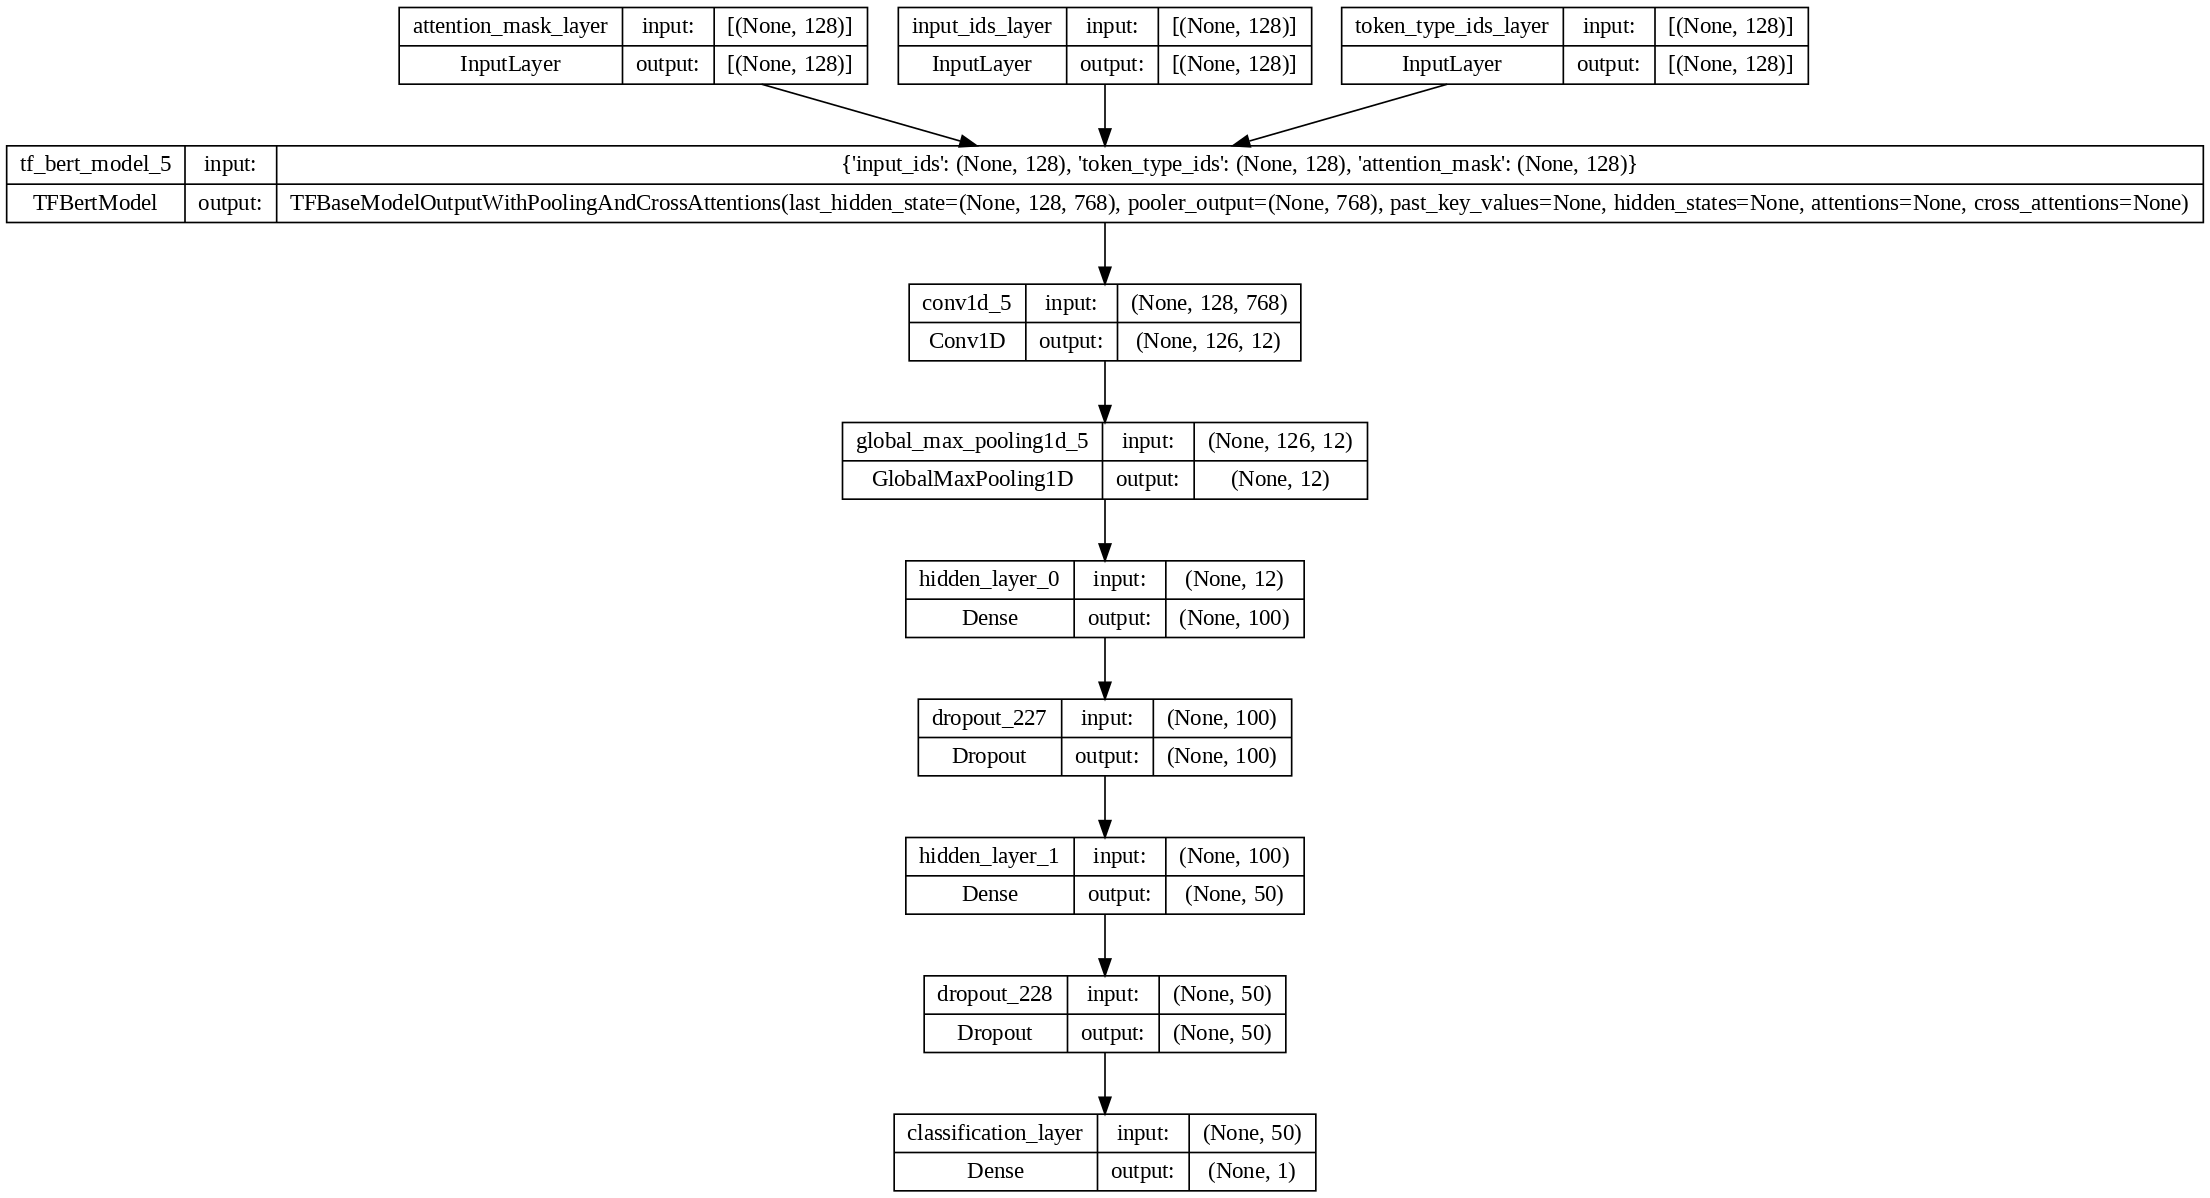

In [ ]:
tf.keras.utils.plot_model(bert_with_cnn_head_model, show_shapes=True, dpi=120)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_classification_layer_accuracy",
    mode="max",
    save_best_only=True
)

bert_with_cnn_head_history = bert_with_cnn_head_model.fit(
    [X_train["input_ids"], X_train["token_type_ids"], X_train["attention_mask"]],
    Y_train,
    validation_data=([X_test["input_ids"], X_test["token_type_ids"], X_test["attention_mask"]], Y_test),
    batch_size=32,
    epochs=25,
    callbacks=[checkpoint_callback]
)

bert_with_cnn_head_model.load_weights(checkpoint_filepath)

Epoch 1/25


KeyboardInterrupt: ignored

In [ ]:
!mkdir -p {project_dir}/bert_with_cnn_head/checkpoint

In [ ]:
bert_with_cnn_head_model.save_weights(f"{project_dir}/bert_with_cnn_head/checkpoint")

In [ ]:
bert_with_cnn_head_model.load_weights(f"{project_dir}/bert_with_cnn_head/checkpoint")

# Evaluation

In [ ]:
plot_train_test_loss(bert_with_cnn_head_history)

NameError: ignored

In [ ]:
Y_pred, conv = bert_with_cnn_head_model.predict([X_test["input_ids"], X_test["token_type_ids"], X_test["attention_mask"]])

18/18 [==============================] - 12s 266ms/step


In [ ]:
print("\nTest metrics:")
precision, recall, f1 = compute_metrics(Y_test, Y_pred)
print(f"Precision: {precision:0.4f}")
print(f"Recall:    {recall:0.4f}")
print(f"F1 Score:  {f1:00.4f}")


Test metrics:
Precision: 0.7760
Recall:    0.8786
F1 Score:  0.8241


# Evaluation

In [ ]:
Y_pred_int = tf.math.round(Y_pred)
Y_test_int = [int(label) for label in Y_test]
print('Predictions')
print(Y_pred_int[0:11])
print('Labels')
print(Y_test_int[0:11])

Predictions
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(11, 1), dtype=float32)
Labels
[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


Text(50.722222222222214, 0.5, 'True Label')

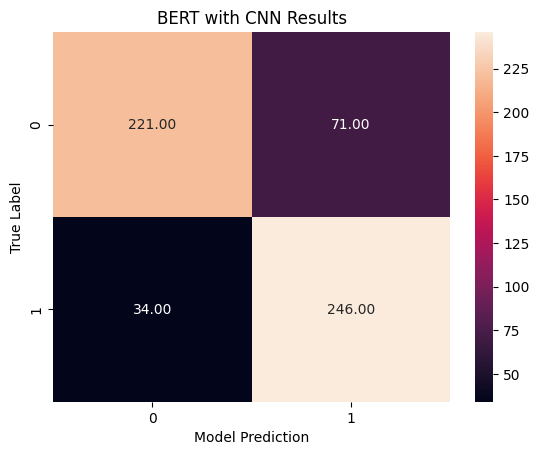

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.title('BERT with CNN Results')
sns.heatmap(confusion_matrix(Y_test_int, Y_pred_int), annot = True, fmt = '.2f')
plt.xlabel('Model Prediction')
plt.ylabel('True Label')

In [ ]:
# Instance that the model did correctly predict as offensive
test_df.tweet.tolist()[1]

'AT_MENTION don&#8217;t be a hurt little faggot'

In [ ]:
# The model incorrectly classified as not offensive
test_df.tweet.tolist()[10]

'AT_MENTION shut your legs hoe'

# Visualize Overall Attention

Extract convolution layer activations for eaach 3-gram and visualize them.

In [ ]:
def get_token_weights(row):
    tokens = bert_tokenizer(
        [row.tweet],
        max_length=MAX_SEQUENCE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
    )
    detokens = bert_tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])
    max_idx = detokens.index("[SEP]")
    tokens_slice = detokens[1:max_idx]
    pred, conv = bert_with_cnn_head_model.predict([tokens["input_ids"], tokens["token_type_ids"], tokens["attention_mask"]], verbose=False)
    conv_sum = tf.linalg.normalize(tf.math.reduce_sum(conv.reshape(126, 12), 1))[0].numpy()
    weights = [0] * 128
    for i, weight in enumerate(conv_sum):
        weights[i  ] += weight
        weights[i+1] += weight
        weights[i+2] += weight
    weights = np.array(weights[1:max_idx])
    weights = weights / np.linalg.norm(weights)
    token_weights = list(zip(tokens_slice, weights))
    return token_weights

In [ ]:
w = get_token_weights(test_df.iloc[6])
w

[('at', 0.07429030143592437),
 ('_', 0.1080160654978143),
 ('mention', 0.09749382817093612),
 ('oh', 0.12817980536947152),
 ('shut', 0.18565482283514445),
 ('your', 0.23422102363810823),
 ('mouth', 0.22850208469677727),
 ('i', 0.17278118654028682),
 ('was', 0.1435903353509524),
 ('talk', 0.14975997748334638),
 ('##in', 0.1816908624525699),
 ('about', 0.19312754572035076),
 ('the', 0.24581186382021064),
 ('morning', 0.31432239223873376),
 ('you', 0.4011303009999832),
 ('fa', 0.42927483227512264),
 ('##g', 0.4095413740301743)]

In [ ]:
def visualize_weights(is_hatespeech, weight, thresh=0):
    html = "<p style='font-size: 12pt; line-height: 2'>\n"
    if is_hatespeech:
        html += f"<span style='padding: 3px; background-color: #ff9900'>Label: Hate Speech</span>\n"
    else:
        html += f"<span style='padding: 3px; background-color: #00cc99'>Label: Not Hate Speech</span>\n"
    for token, score in weight:
        if score > thresh:
            color = int((1-score) * 255)
        else:
            color = 255
        html += f"<span style='padding: 3px; background-color: #ff{color:02x}{color:02x}'>{token}</span>\n"
    html += "</p>\n"
    return HTML(html)

In [ ]:
def test_row(n, thresh=0):
    row = test_df.iloc[n]
    token_attn = get_token_weights(row)
    display(visualize_weights(row.is_hatespeech, token_attn, thresh))

In [ ]:
test_row(6)

In [ ]:
test_row(17)

In [ ]:
test_row(18)

In [ ]:
test_row(20)

The sum approach provides best explanation for both positive and negative cases.

In [ ]:
test_row(33)

In [ ]:
test_row(37)

In [ ]:
test_row(43)

In [ ]:
test_row(69)

# Evaluating Attention

Use the eval data from the BERT attention notebook.

In [ ]:
with open(f"{project_dir}/attn_eval_candidates.json") as f:
    eval_candidates = json.load(f)

In [ ]:
# Contains candidate phrases for each of the hate speech tweets in the sample. We can use this to run ROUGE-1.
eval_candidates["1476"]

['white', 'trash']

In [ ]:
# This is the corresponding row in the data frame showing the original text. We selected
# a candidate set of words that are most indicative of hate speech.
test_df.loc[1476]

count                                                  3
hate_speech                                          1.0
offensive_language                                   0.0
neither                                              0.0
class                                                  0
tweet                 #California is full of white trash
is_hatespeech                                       True
Name: 1476, dtype: object

In [ ]:
!pip install -q keras-nlp rouge-score

In [ ]:
import keras_nlp

Using TensorFlow backend


In [ ]:
y_true = "helo world"
y_pred = "goodbye peeps"

rouge1 = keras_nlp.metrics.RougeL()
rouge1(y_true, y_pred)

{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [ ]:
def run_rouge(eval_candidates, token_attns, thresh):
    """ Run ROUGE analysis for the 100 tweets sampled from the is_hatespeech class. """
    references = list()
    candidates = list()

    for idx, candidate in eval_candidates.items():
        # Create the reference:
        token_attn = token_attns[idx]
        references.append(" ".join(
            token for token, score in token_attn if score > thresh
        ))

        # Create the candidate
        candidates.append(" ".join(candidate))

    print("Showing first 5 references and candidates")
    for i in range(5):
        print(f"{i}: {references[i]} -- {candidates[i]}")

    rouge1 = keras_nlp.metrics.RougeL()
    f1 = rouge1(candidates, references)["f1_score"]
    print(f"ROUGE-1 score: {f1:0.4f}")
    return f1

In [ ]:
def get_eval_token_weights(eval_candidates):
    """ Get token weights for each item in the eval set. """
    token_weights = {}
    for idx, candidate in eval_candidates.items():
        row = test_df.loc[int(idx)]
        token_weights[idx] = get_token_weights(row)
    return token_weights

In [ ]:
%%time
eval_token_weights = get_eval_token_weights(eval_candidates)

CPU times: user 18.9 s, sys: 598 ms, total: 19.5 s
Wall time: 27.4 s


In [ ]:
f1 = run_rouge(eval_candidates, eval_token_weights, thresh=0.25)

Showing first 5 references and candidates
0: california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: is a fa ##gg ##ot . suspend him on those -- fa ##gg ##ot
3: bitch ##es kill think ##in they really got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: birthday freshman fa ##gg ##ots -- fa ##gg ##ots
ROUGE-1 score: 0.4456


In [ ]:
def grid_search_attn_thresh(start, end, step):
    best_t, best_f1 = -1, -1
    """ Grid search over attention thresholds to find the one with best ROUGE score. """
    t = start
    while t <= end:
        print(f"threshold={t}")
        f1 = run_rouge(eval_candidates, eval_token_weights, t)
        if f1 > best_f1:
          best_t, best_f1 = t, f1
        t += step
    print(f"best f1={best_f1} at t={best_t}")

In [ ]:
%%time
grid_search_attn_thresh(0, 1, 0.1)

threshold=0
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: rt at _ mention : at _ mention at _ mention joshua is a fa ##gg ##ot . just suspend him on those grounds -- fa ##gg ##ot
3: dyke bitch ##es kill me think ##in they really got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: rt at _ mention : happy birthday freshman fa ##gg ##ots at _ mention at _ mention -- fa ##gg ##ots
ROUGE-1 score: 0.4082
threshold=0.1
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: mention joshua is a fa ##gg ##ot . just suspend him on those grounds -- fa ##gg ##ot
3: dyke bitch ##es kill me think ##in they really got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: rt at _ mention : happy birthday freshman fa ##gg ##ots at _ mention -- fa ##gg ##ots
ROUGE-1 score: 0.4317
threshold=0.2
Showing first 5 referen

In [ ]:
grid_search_attn_thresh(0.15, 0.25, 0.01)

threshold=0.15
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: joshua is a fa ##gg ##ot . just suspend him on those grounds -- fa ##gg ##ot
3: dyke bitch ##es kill me think ##in they really got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: at : happy birthday freshman fa ##gg ##ots at _ -- fa ##gg ##ots
ROUGE-1 score: 0.4886
threshold=0.16
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate fat bitch ##es
2: joshua is a fa ##gg ##ot . just suspend him on those grounds -- fa ##gg ##ot
3: dyke bitch ##es kill me think ##in they really got ho ##es lo ##l -- dyke bitch ##es kill ho ##es
4: at happy birthday freshman fa ##gg ##ots at -- fa ##gg ##ots
ROUGE-1 score: 0.5051
threshold=0.17
Showing first 5 references and candidates
0: # california is full of white trash -- white trash
1: i hate fat bitch ##es -- hate 

The best ROUGE score is 0.5389 when the attn threshold is set to 0.19.

Visualize a few tweets again with this threshold in place:

In [ ]:
test_row(6, thresh=0.19)

In [ ]:
test_row(17, thresh=0.19)

In [ ]:
test_row(43, thresh=0.19)

In [ ]:
test_row(69, thresh=0.19)